## Imports:

In [57]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Importerer data:

In [58]:
df = pd.read_csv("../data/processed_data/train.csv")

C:\Users\Tobias\AppData\Local\Temp\ipykernel_4072\540487812.py:1: DtypeWarning:

Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.



# lager korelasjons matrise:

In [59]:
df_filtered = df[df["flights_cnt"] != 0]
numeric_df = df_filtered.select_dtypes(include="number")
correlation_matrix = numeric_df.corr()

fig = px.imshow(correlation_matrix,
                labels=dict(x="Features", y="Features", color="Correlation"),
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='RdBu_r',
                aspect="auto")

# Update layout to ensure all y-axis labels are shown
fig.update_layout(
    yaxis=dict(
        tickmode='linear',  # Ensure all y-axis ticks are included
        tick0=0,            # Starting tick
        dtick=1             # Step size for ticks (1 ensures every category gets a label)
    ),xaxis=dict(
        tickmode='linear',  # Ensure all x-axis ticks are included
        tick0=0,            # Starting tick
        dtick=1             # Step size for ticks (1 ensures every category gets a label)
    ),
    autosize=False,  # Disable automatic size adjustment
    height=800,     # Set the height to ensure enough space for labels
    width=800       # Adjust width if necessary
)

fig.show()

# Fligth count inspection:

<Axes: >

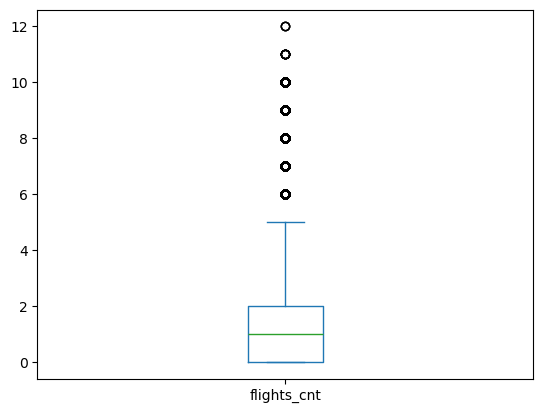

In [60]:
df["flights_cnt"].plot.box()

<Axes: >

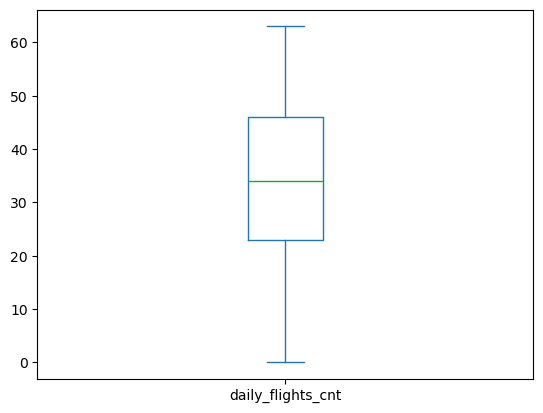

In [61]:
df["daily_flights_cnt"].plot.box()

Number of flights v target:

In [62]:
import plotly.graph_objects as go

target_avg = df.groupby("flights_cnt")[["target_actual","target_sched"]].mean().round(2)

fig = go.Figure()

# Add each column as its own bar trace
for col in target_avg.columns:
    fig.add_trace(
        go.Bar(
            x=target_avg.index,
            y=target_avg[col],
            name=col,
            text=target_avg[col],
            textposition='auto'
        )
    )

fig.update_layout(
    title="Average target value per flightcount",
    xaxis_title="Flightcount",
    yaxis_title="Average of target",
    barmode='group'  # or 'stack'
)

fig.show()


Adding mismatch:

In [63]:
def mismatch_type(row):
    if row["target_sched"] == 1 and row["target_actual"] == 0:
        return "False Positive"
    elif row["target_sched"] == 0 and row["target_actual"] == 1:
        return "False Negative"
    else:
        return "Correct"

df["mismatch"] = df.apply(mismatch_type, axis=1)

In [64]:
df_flight = df.groupby(["daily_flights_cnt", "mismatch"]).size().reset_index(name="count")
df_total_flight = df.groupby("daily_flights_cnt").size().reset_index(name="total")

df_flight = df_flight.merge(df_total_flight, on="daily_flights_cnt")
df_flight["percent"] = df_flight["count"] / df_flight["total"] * 100

px.line(df_flight, x="daily_flights_cnt", y="percent", color="mismatch",
        title="Mismatch-type etter antall flyvninger per dag",
        labels={"daily_flights_cnt": "Antall fly per dag", "percent": "Andel (%)"})

# Forskjeller i flyplass grupper

In [66]:
#compute sums
flight_sum = (
    df.groupby("airport_group")[["flights_cnt"]]
      .sum()
)

fig = go.Figure()

# Add each column as its own bar trace
for col in flight_sum.columns:
    fig.add_trace(
        go.Bar(
            x=flight_sum.index,
            y=flight_sum[col],
            name=col,
            text=flight_sum[col],
            textposition='auto'
        )
    )

fig.update_layout(
    title="Number of flights per group",
    xaxis_title="Group",
    yaxis_title="Sum",
    barmode='group'  # or 'stack',
)

fig.show()


In [67]:
df_group = df.groupby(["airport_group", "mismatch"]).size().reset_index(name="count")
df_total_group = df.groupby("airport_group").size().reset_index(name="total")

df_group = df_group.merge(df_total_group, on="airport_group")
df_group["percent"] = df_group["count"] / df_group["total"] * 100

px.bar(df_group, x="airport_group", y="percent", color="mismatch",
        title="Mismatch-type etter flyplassgruppe",
        labels={"airport_group": "Flyplassgruppe", "percent": "Andel (%)"})

# Forskjeller i airline

In [ ]:
#compute sums
flight_sum = (
    df.groupby("airline")[["flights_cnt"]]
      .sum()
)

fig = go.Figure()

# Add each column as its own bar trace
for col in flight_sum.columns:
    fig.add_trace(
        go.Bar(
            x=flight_sum.index,
            y=flight_sum[col],
            name=col,
            text=flight_sum[col],
            textposition='auto'
        )
    )

fig.update_layout(
    title="Number of flights per airline",
    xaxis_title="Airline",
    yaxis_title="Sum",
    barmode='group'  # or 'stack',
)

fig.show()


In [77]:
# Count how many rows (flights) per airline
airline_counts = df["airline"].value_counts()

# Keep only airlines with >100 rows
valid_airlines = airline_counts[airline_counts > 500].index

# Filter df and then compute means
df_filtered = df[df["airline"].isin(valid_airlines)]

df_group = df_filtered.groupby(["airline", "mismatch"]).size().reset_index(name="count")
df_total_group = df_filtered.groupby("airline").size().reset_index(name="total")

df_group = df_group.merge(df_total_group, on="airline")
df_group["percent"] = df_group["count"] / df_group["total"] * 100

px.bar(df_group, x="airline", y="percent", color="mismatch",
        title="Mismatch-type etter Flyselskap",
        labels={"airline": "Flyselskap", "percent": "Andel (%)"})